In [1]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import math
import time
from keras import backend as K
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.tree import ExtraTreeRegressor
from sklearn.metrics import r2_score
import sklearn.metrics as m
from collections import Counter
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

Using TensorFlow backend.


In [2]:
'''
Function that takes in a dataframe and then returns the dictionary of accuracies.
'''

def plot_test(y_test,y_pred,start,end,string="trying"):
    #Plot of testing.
    plt.figure(figsize=(20,10))
    plt.plot(y_test[start:end-1],'r',linestyle="--")
    plt.plot(y_pred[start+1:end],'b')
    plt.legend()
    plt.title(string)
    plt.show()
    
def plot_bar(a,b,start,end,string="trend", overlap=0, length=20, height=10):
    #Plot of testing.
    x = np.array(list(range(214)), dtype=float)
    plt.figure(figsize=(length,height))
    if(overlap == 0):
        plt.bar(x[start:end]-0.5, a[start:end],width=0.2,color='r',align='center')
        plt.bar(x[start:end]-0.2, b[start:end],width=0.2,color='b',align='center')
    else:
        plt.bar(x[start:end], a[start:end],width=0.2,color='r',align='center')
        plt.bar(x[start:end], b[start:end],width=0.2,color='b',align='center')
    plt.title(string)
    plt.show()
    
''' plt.figure(figsize=(20,10))
    plt.plot(y_test[start:end-1],'r',linestyle="--")
    plt.plot(y_pred[start+1:end],'b')
    plt.legend()
    plt.title("Shifted")
    plt.show()
    print ("R2: ",r2_score(y_test[start:end-1],y_pred[start+1:end]))
    print ("MAE: ",mean_absolute_error(y_test[start:end-1],y_pred[start+1:end]))
    print ("RMSE: ",np.sqrt(mean_squared_error(y_test[start:end-1],y_pred[start+1:end])))
'''    
'''
    Neural net model
    ------------------------------------------
    | Arguments                              |
    ------------------------------------------
    | localdf : data                         |
    | localdict : results                    |
    | train_size : training size
    | times : number of times to perform nn  |
    | metric : metric of eval                |
    | num_cols : selection of column         |
    | hour_day : hour of the day             |
    ------------------------------------------
'''

def nn_model(ndf,times,metric,train_size,act = 'relu'):
    for counter in range(times):
        x = ndf[ndf.columns[:-1]]
        y = ndf[ndf.columns[-1]]

        #train_size = int(70*x.shape[0]/100)
        #X_train,X_test,y_train,y_test = train_test_split(x.values,y.values,test_size=0.2,random_state=1)
        X_train = x.values[:train_size]
        y_train = y.values[:train_size]

        X_test = x.values[train_size:]
        y_test = y.values[train_size:]
        
        model = Sequential()

        #Hidden Layers.
        model.add(Dense(24,input_dim=x.shape[1],kernel_initializer='normal', activation=act))
        #model.add(Dense(24,kernel_initializer='normal', activation=act))

        #Output Layer.
        model.add(Dense(1,kernel_initializer='normal',activation='linear'))

        #Compile model.
        model.compile(loss='mean_squared_error',optimizer='adam',metrics=[metric])

        #Fit the model.
        history = model.fit(X_train,y_train,epochs=750,batch_size=5,verbose=1)

        #Final Evaluation of the model.
        y_pred = model.predict(X_test,batch_size=5,verbose=1)
        y_pred[y_pred<0]=0

        r2 = r2_score(y_test,y_pred)
        rmse = np.sqrt(mean_squared_error(y_test,y_pred))
        mae = mean_absolute_error(y_test,y_pred)

        print ("R2 Score : ",r2)
        print ("RMSE : ",rmse)
        print ("MAE : ",mae)
        model.summary()
        weights1 = model.layers[0].get_weights()[0]
        biases1 = model.layers[0].get_weights()[1]
        weights2 = model.layers[1].get_weights()[0]
        biases2 = model.layers[1].get_weights()[1]
        print ("Activation used : ",act)
        plot_test(y_test,y_pred,0,100,"")
        print("y_test", y_test)
        print("y_pred", y_pred)
        del model        
    return history,y_test,y_pred,weights1, weights2, biases1, biases2 

In [25]:
'''
Testing the models on house '3273'.
'''
thermal_data = pd.read_pickle('../DataSets/New_Pecan_Street/load_data_3273.pkl')

thermal_data = thermal_data[["localhour","air1","furnace1","waterheater1"]]
thermal_data["total"] = thermal_data["air1"] + thermal_data["furnace1"] + thermal_data["waterheater1"]
thermal_data.iloc[:,[1,2,3,4]] = thermal_data.iloc[:,[1,2,3,4]].mul(1000)
thermal_data.shape

(33260, 5)

In [26]:
'''
Hourly load of house 3273 for house 3273.
'''
# 4 - 10.

summer14 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2014-04")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2014-11")].index[0] - 1
summer14 = thermal_data.iloc[start:end+1]

summer15 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2015-04")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2015-11")].index[0] - 1
summer15 = thermal_data.iloc[start:end+1]

summer16 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2016-04")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2016-11")].index[0] - 1
summer16 = thermal_data.iloc[start:end+1]

summer17 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2017-04")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2017-11")].index[0] - 1
summer17 = thermal_data.iloc[start:end+1]

'''
Winter splitting 
'''
# 11 - 3

winter13 = pd.DataFrame()
start = 0
end = thermal_data[thermal_data["localhour"].str.contains("2014-04")].index[0] - 1
winter13 = thermal_data.iloc[start:end+1]

winter14 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2014-11")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2015-04")].index[0] - 1
winter14 = thermal_data.iloc[start:end+1]

winter15 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2015-11")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2016-04")].index[0] - 1
winter15 = thermal_data.iloc[start:end+1]

winter16 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2016-11")].index[0]
end = thermal_data[thermal_data["localhour"].str.contains("2017-04")].index[0] - 1
winter16 = thermal_data.iloc[start:end+1]

winter17 = pd.DataFrame()
start = thermal_data[thermal_data["localhour"].str.contains("2017-11")].index[0]
end = 0
winter17 = thermal_data.iloc[start:]

In [27]:
summers = pd.concat([summer14,summer15,summer16,summer17],axis=0)
winters = pd.concat([winter13,winter14,winter15,winter16,winter17],axis=0)
summers.to_csv("summers3273.csv",sep=",",encoding="utf-8")
winters.to_csv("winters3273.csv",sep=",",encoding="utf-8")

In [28]:
'''
Converting the hourly profile into a daily load profile.
'''
def transpose_and_hours_to_day(xdf, ydf):
    nhrs = int(xdf["total"].values.shape[0]/24)
    temp_y = np.ndarray(shape=(nhrs,))
    temp_x = np.ndarray(shape=(nhrs,24))
    val = []
    val2 = []
    for i in range(nhrs):
        #Take only the loads corresponding to one whole day, starting from the hour the datframe starts from.
        val = xdf["total"].values[24*i:24*(i+1)]
        val2 = ydf["total"].values[24*i:24*(i+1)]
        temp_y[i] = np.sum(val2)
        temp_x[i]=val.T
        
    y = temp_y[1:]
    # ------------------------------------applying SAVGOL filter------------------------------
    #
    # parameters - (array to apply filter, no. of instances to consider, degree of polynomial equation used)
    y = savgol_filter(y,11,3)
    y = pd.DataFrame(y)
    y.columns = ['cur_day_load']
    print(y.shape)
    x = temp_y[:-1]
    # ------------------------------------applying SAVGOL filter------------------------------
    #
    # parameters - (array to apply filter, no. of instances to consider, degree of polynomial equation used)
    x = savgol_filter(x,11,3)
    x = pd.DataFrame(x)
    x.columns = ['prev_day_load']
    print(x.shape)
    return pd.concat([x,y],axis=1)

In [29]:
summer1 = transpose_and_hours_to_day(summer16,summer16)
summer2 = transpose_and_hours_to_day(summer15,summer15)
#summer3 = transpose_and_hours_to_day(summer14)

(167, 1)
(167, 1)
(213, 1)
(213, 1)


In [30]:
'''for summer16 use last 123 instances'''
summer1 = summer1.iloc[-123:,:]

(123, 2)
(213, 2)


In [32]:
#summer1.values[:,-1] = abs(summer1.values[:,-1] - 4564.8)
summer = pd.concat([summer1,summer2],axis=0)
print (summer.shape)

(336, 2)


Epoch 1/750
123/123 [==============================] - 1s 4ms/step - loss: 94609309.6585 - mean_squared_error: 94609309.6585
Epoch 2/750
123/123 [==============================] - 0s 1ms/step - loss: 87048798.7967 - mean_squared_error: 87048798.7967
Epoch 3/750
123/123 [==============================] - 0s 1ms/step - loss: 76496637.5285 - mean_squared_error: 76496637.5285
Epoch 4/750
123/123 [==============================] - 0s 1ms/step - loss: 62101534.1789 - mean_squared_error: 62101534.1789
Epoch 5/750
123/123 [==============================] - 0s 1ms/step - loss: 45604391.5772 - mean_squared_error: 45604391.5772
Epoch 6/750
123/123 [==============================] - 0s 2ms/step - loss: 29339365.3902 - mean_squared_error: 29339365.3902
Epoch 7/750
123/123 [==============================] - 0s 1ms/step - loss: 15961468.4309 - mean_squared_error: 15961468.4309
Epoch 8/750
123/123 [==============================] - 0s 1ms/step - loss: 7230248.8841 - mean_squared_error: 7230248.8841
Ep

123/123 [==============================] - 0s 1ms/step - loss: 436990.4268 - mean_squared_error: 436990.4268
Epoch 134/750
123/123 [==============================] - 0s 1ms/step - loss: 438397.9903 - mean_squared_error: 438397.9903
Epoch 135/750
123/123 [==============================] - 0s 1ms/step - loss: 442081.2347 - mean_squared_error: 442081.2347
Epoch 136/750
123/123 [==============================] - 0s 1ms/step - loss: 443861.1428 - mean_squared_error: 443861.1428
Epoch 137/750
123/123 [==============================] - 0s 1ms/step - loss: 439307.9798 - mean_squared_error: 439307.9798
Epoch 138/750
123/123 [==============================] - 0s 2ms/step - loss: 441466.8515 - mean_squared_error: 441466.8515
Epoch 139/750
123/123 [==============================] - 0s 974us/step - loss: 439495.1114 - mean_squared_error: 439495.1114
Epoch 140/750
123/123 [==============================] - 0s 1ms/step - loss: 436366.8128 - mean_squared_error: 436366.8128
Epoch 141/750
123/123 [=====

123/123 [==============================] - 0s 1ms/step - loss: 435223.7508 - mean_squared_error: 435223.7508
Epoch 266/750
123/123 [==============================] - 0s 1ms/step - loss: 450407.5758 - mean_squared_error: 450407.5758
Epoch 267/750
123/123 [==============================] - 0s 1ms/step - loss: 440441.2427 - mean_squared_error: 440441.2427
Epoch 268/750
123/123 [==============================] - 0s 1ms/step - loss: 444290.9996 - mean_squared_error: 444290.9996
Epoch 269/750
123/123 [==============================] - 0s 899us/step - loss: 445923.0371 - mean_squared_error: 445923.0371
Epoch 270/750
123/123 [==============================] - 0s 1ms/step - loss: 447002.8543 - mean_squared_error: 447002.8543
Epoch 271/750
123/123 [==============================] - 0s 1ms/step - loss: 442629.2315 - mean_squared_error: 442629.2315
Epoch 272/750
123/123 [==============================] - 0s 1ms/step - loss: 440030.2059 - mean_squared_error: 440030.2059
Epoch 273/750
123/123 [=====

123/123 [==============================] - 0s 1ms/step - loss: 435263.3303 - mean_squared_error: 435263.3303
Epoch 398/750
123/123 [==============================] - 0s 1ms/step - loss: 437502.1212 - mean_squared_error: 437502.1212
Epoch 399/750
123/123 [==============================] - 0s 1ms/step - loss: 439726.9474 - mean_squared_error: 439726.9474
Epoch 400/750
123/123 [==============================] - 0s 1ms/step - loss: 456193.9892 - mean_squared_error: 456193.9892
Epoch 401/750
123/123 [==============================] - 0s 2ms/step - loss: 437913.6632 - mean_squared_error: 437913.6632
Epoch 402/750
123/123 [==============================] - 0s 2ms/step - loss: 449903.0089 - mean_squared_error: 449903.0089
Epoch 403/750
123/123 [==============================] - 0s 1ms/step - loss: 433118.6756 - mean_squared_error: 433118.6756
Epoch 404/750
123/123 [==============================] - 0s 1ms/step - loss: 435398.0614 - mean_squared_error: 435398.0614
Epoch 405/750
123/123 [=======

Epoch 529/750
123/123 [==============================] - 0s 1ms/step - loss: 435660.5419 - mean_squared_error: 435660.5419
Epoch 530/750
123/123 [==============================] - 0s 2ms/step - loss: 438264.6810 - mean_squared_error: 438264.6810
Epoch 531/750
123/123 [==============================] - 0s 2ms/step - loss: 443241.3321 - mean_squared_error: 443241.3321
Epoch 532/750
123/123 [==============================] - 0s 1ms/step - loss: 438155.4482 - mean_squared_error: 438155.4482
Epoch 533/750
123/123 [==============================] - 0s 2ms/step - loss: 442401.6128 - mean_squared_error: 442401.6128
Epoch 534/750
123/123 [==============================] - 0s 1ms/step - loss: 446895.1536 - mean_squared_error: 446895.1536
Epoch 535/750
123/123 [==============================] - 0s 2ms/step - loss: 452210.7503 - mean_squared_error: 452210.7503
Epoch 536/750
123/123 [==============================] - 0s 1ms/step - loss: 443059.4785 - mean_squared_error: 443059.4785
Epoch 537/750
12

123/123 [==============================] - 0s 2ms/step - loss: 478646.3545 - mean_squared_error: 478646.3545
Epoch 662/750
123/123 [==============================] - 0s 1ms/step - loss: 445825.6693 - mean_squared_error: 445825.6693
Epoch 663/750
123/123 [==============================] - 0s 1ms/step - loss: 440442.7107 - mean_squared_error: 440442.7107
Epoch 664/750
123/123 [==============================] - 0s 1ms/step - loss: 442808.3439 - mean_squared_error: 442808.3439
Epoch 665/750
123/123 [==============================] - 0s 1ms/step - loss: 438338.3366 - mean_squared_error: 438338.3366
Epoch 666/750
123/123 [==============================] - 0s 1ms/step - loss: 439342.8648 - mean_squared_error: 439342.8648
Epoch 667/750
123/123 [==============================] - 0s 1ms/step - loss: 442499.5960 - mean_squared_error: 442499.5960
Epoch 668/750
123/123 [==============================] - 0s 1ms/step - loss: 442469.3449 - mean_squared_error: 442469.3449
Epoch 669/750
123/123 [=======

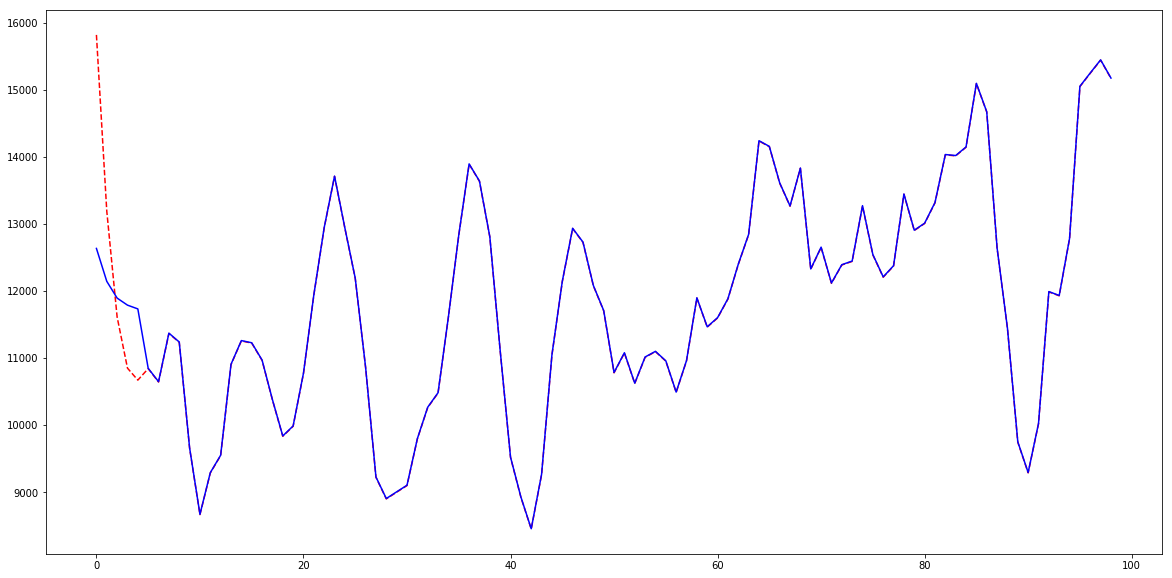

y_test [ 15815.05128205  13187.16631702  11609.05353535  10847.40192308
  10668.9004662   10840.23815074  10640.79254079  11364.35104895
  11232.10784771   9654.24553225   8663.64094794   9284.16029526
   9544.37090132  10900.02342657  11253.33034188  11220.67688423
  10963.25905206  10373.49405594   9831.71658897   9980.44250194
  10768.45714841  11935.58387723  12936.96849262  13705.43247863
  12932.21961927  12184.19386169  10856.68710179   9220.17097902
   8898.33453768   8998.21371406   9096.89296814   9791.0989899
  10259.69219114  10476.3526418   11608.07109557  12826.96177156
  13887.4504662   13631.61689977  12801.97229992  11105.16717172
   9515.86289821   8922.16565657   8448.16351981   9259.30998446
  11041.72975913  12135.88275058  12927.79848485  12721.39005439
  12075.62008547  11701.1999223   10777.99327894  11072.25804196
  10618.38752914  11008.72991453  11092.9463481   10951.51285936
  10485.69052059  10955.46515152  11891.41950272  11458.8543512
  11595.38783994  11

In [43]:
'''
Summer of house 3273.
'''
model_history,y_test,y_pred,w1,w2,b1,b2 = nn_model(summer,1,"mean_squared_error",summer1.shape[0])

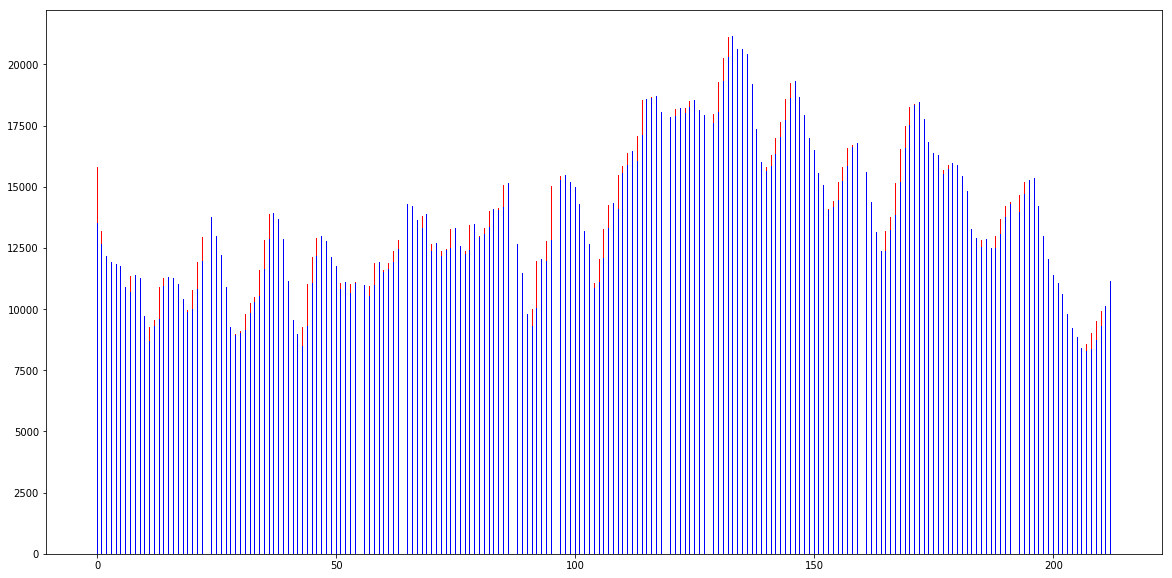

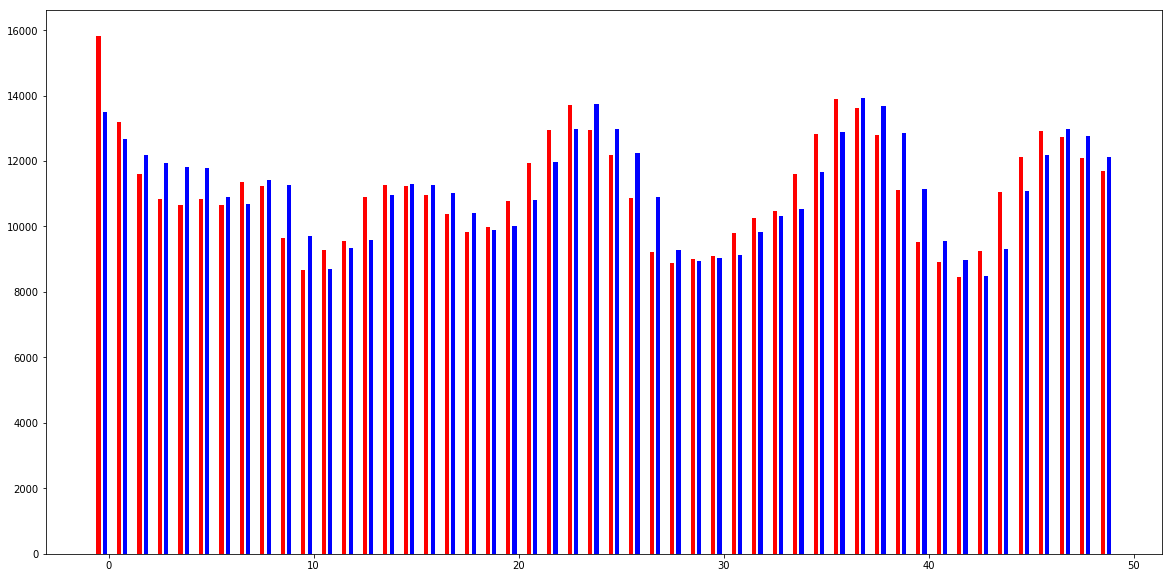

In [38]:
# finding mean error to find if the summers are always off by a certain value
# red - 1st argument
# blue - 2nd argument
'''
1st graph is just to see where all y_test is more than y_pred
2nd graph is used to compare them side by side - so give small window size for clarity
'''
plot_bar(y_test.tolist(),y_pred.T[0].tolist(),0,len(y_test),"",1)
plot_bar(y_test.tolist(),y_pred.T[0].tolist(),0,50,"")

In [40]:
# taking 2 winters and creating the total daily load format for feeding into NN
winter1 = transpose_and_hours_to_day(winter16,winter16)
winter2 = transpose_and_hours_to_day(winter15,winter15)

(150, 1)
(150, 1)
(151, 1)
(151, 1)


In [41]:
winter = pd.concat([winter1,winter2],axis=0)
print (winter.shape)

(301, 2)


Epoch 1/750
150/150 [==============================] - 0s 3ms/step - loss: 41818060.2333 - mean_squared_error: 41818060.2333
Epoch 2/750
150/150 [==============================] - 0s 1ms/step - loss: 39705323.8000 - mean_squared_error: 39705323.8000
Epoch 3/750
150/150 [==============================] - 0s 1ms/step - loss: 36419762.7333 - mean_squared_error: 36419762.7333
Epoch 4/750
150/150 [==============================] - 0s 1ms/step - loss: 31653451.6333 - mean_squared_error: 31653451.6333
Epoch 5/750
150/150 [==============================] - 0s 1ms/step - loss: 25589650.1667 - mean_squared_error: 25589650.1667
Epoch 6/750
150/150 [==============================] - 0s 1ms/step - loss: 19386946.0667 - mean_squared_error: 19386946.0667
Epoch 7/750
150/150 [==============================] - 0s 1ms/step - loss: 13224224.7667 - mean_squared_error: 13224224.7667
Epoch 8/750
150/150 [==============================] - 0s 1ms/step - loss: 8345727.3500 - mean_squared_error: 8345727.3500
Ep

150/150 [==============================] - 0s 1ms/step - loss: 1332839.5156 - mean_squared_error: 1332839.5156: 0s - loss: 1481686.5534 - mean_squared_error: 1481686.55
Epoch 68/750
150/150 [==============================] - 0s 1ms/step - loss: 1323953.2318 - mean_squared_error: 1323953.2318
Epoch 69/750
150/150 [==============================] - 0s 1ms/step - loss: 1329291.7510 - mean_squared_error: 1329291.7510
Epoch 70/750
150/150 [==============================] - 0s 1ms/step - loss: 1335894.1419 - mean_squared_error: 1335894.1419
Epoch 71/750
150/150 [==============================] - 0s 1ms/step - loss: 1325007.1896 - mean_squared_error: 1325007.1896
Epoch 72/750
150/150 [==============================] - 0s 2ms/step - loss: 1346779.7590 - mean_squared_error: 1346779.7590
Epoch 73/750
150/150 [==============================] - 0s 1ms/step - loss: 1332887.1540 - mean_squared_error: 1332887.1540
Epoch 74/750
150/150 [==============================] - 0s 2ms/step - loss: 1323212.508

150/150 [==============================] - 0s 1ms/step - loss: 1348543.4859 - mean_squared_error: 1348543.4859
Epoch 133/750
150/150 [==============================] - 0s 2ms/step - loss: 1337416.1861 - mean_squared_error: 1337416.1861
Epoch 134/750
150/150 [==============================] - 0s 1ms/step - loss: 1336846.5312 - mean_squared_error: 1336846.5312
Epoch 135/750
150/150 [==============================] - 0s 2ms/step - loss: 1324592.2359 - mean_squared_error: 1324592.2359
Epoch 136/750
150/150 [==============================] - 0s 1ms/step - loss: 1342778.2253 - mean_squared_error: 1342778.2253
Epoch 137/750
150/150 [==============================] - 0s 1ms/step - loss: 1325908.4909 - mean_squared_error: 1325908.4909
Epoch 138/750
150/150 [==============================] - 0s 1ms/step - loss: 1340248.4714 - mean_squared_error: 1340248.4714
Epoch 139/750
150/150 [==============================] - 0s 2ms/step - loss: 1331564.0047 - mean_squared_error: 1331564.0047
Epoch 140/750


150/150 [==============================] - 0s 1ms/step - loss: 1347004.3208 - mean_squared_error: 1347004.3208
Epoch 198/750
150/150 [==============================] - 0s 1ms/step - loss: 1329484.1651 - mean_squared_error: 1329484.1651
Epoch 199/750
150/150 [==============================] - 0s 1ms/step - loss: 1339531.1513 - mean_squared_error: 1339531.1513
Epoch 200/750
150/150 [==============================] - 0s 1ms/step - loss: 1330736.8651 - mean_squared_error: 1330736.8651
Epoch 201/750
150/150 [==============================] - 0s 1ms/step - loss: 1326991.2646 - mean_squared_error: 1326991.2646
Epoch 202/750
150/150 [==============================] - 0s 906us/step - loss: 1331589.5510 - mean_squared_error: 1331589.5510
Epoch 203/750
150/150 [==============================] - 0s 1ms/step - loss: 1327380.3878 - mean_squared_error: 1327380.3878
Epoch 204/750
150/150 [==============================] - 0s 1ms/step - loss: 1336246.6168 - mean_squared_error: 1336246.6168
Epoch 205/75

150/150 [==============================] - 0s 1ms/step - loss: 1335451.7578 - mean_squared_error: 1335451.7578
Epoch 263/750
150/150 [==============================] - 0s 1ms/step - loss: 1347168.7448 - mean_squared_error: 1347168.7448
Epoch 264/750
150/150 [==============================] - 0s 2ms/step - loss: 1331000.9691 - mean_squared_error: 1331000.9691
Epoch 265/750
150/150 [==============================] - 0s 2ms/step - loss: 1330113.4174 - mean_squared_error: 1330113.4174
Epoch 266/750
150/150 [==============================] - 0s 2ms/step - loss: 1327429.9526 - mean_squared_error: 1327429.9526
Epoch 267/750
150/150 [==============================] - 0s 1ms/step - loss: 1333831.8319 - mean_squared_error: 1333831.8319
Epoch 268/750
150/150 [==============================] - 0s 2ms/step - loss: 1327885.3477 - mean_squared_error: 1327885.3477
Epoch 269/750
150/150 [==============================] - 0s 1ms/step - loss: 1342353.9010 - mean_squared_error: 1342353.9010
Epoch 270/750


150/150 [==============================] - 0s 1ms/step - loss: 1340761.1315 - mean_squared_error: 1340761.1315
Epoch 328/750
150/150 [==============================] - 0s 1ms/step - loss: 1324242.5630 - mean_squared_error: 1324242.5630
Epoch 329/750
150/150 [==============================] - 0s 1ms/step - loss: 1339554.5810 - mean_squared_error: 1339554.5810
Epoch 330/750
150/150 [==============================] - 0s 1ms/step - loss: 1335482.1885 - mean_squared_error: 1335482.1885
Epoch 331/750
150/150 [==============================] - 0s 1ms/step - loss: 1351951.0021 - mean_squared_error: 1351951.0021
Epoch 332/750
150/150 [==============================] - 0s 1ms/step - loss: 1326528.0643 - mean_squared_error: 1326528.0643
Epoch 333/750
150/150 [==============================] - 0s 1ms/step - loss: 1326767.6323 - mean_squared_error: 1326767.6323
Epoch 334/750
150/150 [==============================] - 0s 1ms/step - loss: 1341846.3147 - mean_squared_error: 1341846.3147
Epoch 335/750


150/150 [==============================] - 0s 1ms/step - loss: 1324172.1844 - mean_squared_error: 1324172.1844
Epoch 393/750
150/150 [==============================] - 0s 999us/step - loss: 1339715.2750 - mean_squared_error: 1339715.2750
Epoch 394/750
150/150 [==============================] - 0s 1ms/step - loss: 1335443.1000 - mean_squared_error: 1335443.1000
Epoch 395/750
150/150 [==============================] - 0s 1ms/step - loss: 1332210.9159 - mean_squared_error: 1332210.9159
Epoch 396/750
150/150 [==============================] - 0s 1ms/step - loss: 1329555.2273 - mean_squared_error: 1329555.2273
Epoch 397/750
150/150 [==============================] - 0s 914us/step - loss: 1343434.6214 - mean_squared_error: 1343434.6214
Epoch 398/750
150/150 [==============================] - 0s 1ms/step - loss: 1336579.6185 - mean_squared_error: 1336579.6185
Epoch 399/750
150/150 [==============================] - 0s 1ms/step - loss: 1353690.0124 - mean_squared_error: 1353690.0124
Epoch 400/

150/150 [==============================] - 0s 1ms/step - loss: 1321051.7639 - mean_squared_error: 1321051.7639
Epoch 458/750
150/150 [==============================] - 0s 1ms/step - loss: 1333599.9068 - mean_squared_error: 1333599.9068
Epoch 459/750
150/150 [==============================] - 0s 1ms/step - loss: 1359869.2794 - mean_squared_error: 1359869.2794
Epoch 460/750
150/150 [==============================] - 0s 1ms/step - loss: 1322223.4826 - mean_squared_error: 1322223.4826
Epoch 461/750
150/150 [==============================] - 0s 1ms/step - loss: 1349383.9984 - mean_squared_error: 1349383.9984
Epoch 462/750
150/150 [==============================] - 0s 1ms/step - loss: 1332954.3911 - mean_squared_error: 1332954.3911
Epoch 463/750
150/150 [==============================] - 0s 978us/step - loss: 1325145.4268 - mean_squared_error: 1325145.4268
Epoch 464/750
150/150 [==============================] - 0s 1ms/step - loss: 1343846.3745 - mean_squared_error: 1343846.3745
Epoch 465/75

150/150 [==============================] - 0s 1ms/step - loss: 1332668.2184 - mean_squared_error: 1332668.2184
Epoch 523/750
150/150 [==============================] - 0s 1ms/step - loss: 1320133.9240 - mean_squared_error: 1320133.9240
Epoch 524/750
150/150 [==============================] - 0s 1ms/step - loss: 1334037.2484 - mean_squared_error: 1334037.2484
Epoch 525/750
150/150 [==============================] - 0s 956us/step - loss: 1335055.4418 - mean_squared_error: 1335055.4418
Epoch 526/750
150/150 [==============================] - 0s 1ms/step - loss: 1332241.6398 - mean_squared_error: 1332241.6398
Epoch 527/750
150/150 [==============================] - 0s 1ms/step - loss: 1330458.1922 - mean_squared_error: 1330458.1922
Epoch 528/750
150/150 [==============================] - 0s 1ms/step - loss: 1322849.2661 - mean_squared_error: 1322849.2661
Epoch 529/750
150/150 [==============================] - 0s 990us/step - loss: 1324872.8480 - mean_squared_error: 1324872.8480
Epoch 530/

150/150 [==============================] - 0s 1ms/step - loss: 1361451.2081 - mean_squared_error: 1361451.2081
Epoch 587/750
150/150 [==============================] - 0s 1ms/step - loss: 1356052.5193 - mean_squared_error: 1356052.5193
Epoch 588/750
150/150 [==============================] - 0s 1ms/step - loss: 1334946.4263 - mean_squared_error: 1334946.4263
Epoch 589/750
150/150 [==============================] - 0s 1ms/step - loss: 1357519.5984 - mean_squared_error: 1357519.5984
Epoch 590/750
150/150 [==============================] - 0s 1ms/step - loss: 1341075.2008 - mean_squared_error: 1341075.2008
Epoch 591/750
150/150 [==============================] - 0s 1ms/step - loss: 1324215.4424 - mean_squared_error: 1324215.4424
Epoch 592/750
150/150 [==============================] - 0s 924us/step - loss: 1340013.0115 - mean_squared_error: 1340013.0115
Epoch 593/750
150/150 [==============================] - 0s 1ms/step - loss: 1327240.7921 - mean_squared_error: 1327240.7921
Epoch 594/75

150/150 [==============================] - 0s 1ms/step - loss: 1331338.8609 - mean_squared_error: 1331338.8609
Epoch 652/750
150/150 [==============================] - 0s 1ms/step - loss: 1329509.5708 - mean_squared_error: 1329509.5708
Epoch 653/750
150/150 [==============================] - 0s 1ms/step - loss: 1332769.4265 - mean_squared_error: 1332769.4265
Epoch 654/750
150/150 [==============================] - 0s 1ms/step - loss: 1337192.1148 - mean_squared_error: 1337192.1148
Epoch 655/750
150/150 [==============================] - 0s 1ms/step - loss: 1352558.4257 - mean_squared_error: 1352558.4257
Epoch 656/750
150/150 [==============================] - 0s 1ms/step - loss: 1326830.9766 - mean_squared_error: 1326830.9766
Epoch 657/750
150/150 [==============================] - 0s 1ms/step - loss: 1332922.7538 - mean_squared_error: 1332922.7538
Epoch 658/750
150/150 [==============================] - 0s 1ms/step - loss: 1335936.6745 - mean_squared_error: 1335936.6745
Epoch 659/750


150/150 [==============================] - 0s 1ms/step - loss: 1341233.1021 - mean_squared_error: 1341233.1021
Epoch 717/750
150/150 [==============================] - 0s 1ms/step - loss: 1331367.2276 - mean_squared_error: 1331367.2276
Epoch 718/750
150/150 [==============================] - 0s 1ms/step - loss: 1327158.8891 - mean_squared_error: 1327158.8891
Epoch 719/750
150/150 [==============================] - 0s 1ms/step - loss: 1327865.4642 - mean_squared_error: 1327865.4642
Epoch 720/750
150/150 [==============================] - 0s 1ms/step - loss: 1326065.8240 - mean_squared_error: 1326065.8240
Epoch 721/750
150/150 [==============================] - 0s 1ms/step - loss: 1323718.8810 - mean_squared_error: 1323718.8810
Epoch 722/750
150/150 [==============================] - 0s 1ms/step - loss: 1327869.9852 - mean_squared_error: 1327869.9852
Epoch 723/750
150/150 [==============================] - 0s 935us/step - loss: 1335090.2055 - mean_squared_error: 1335090.2055
Epoch 724/75

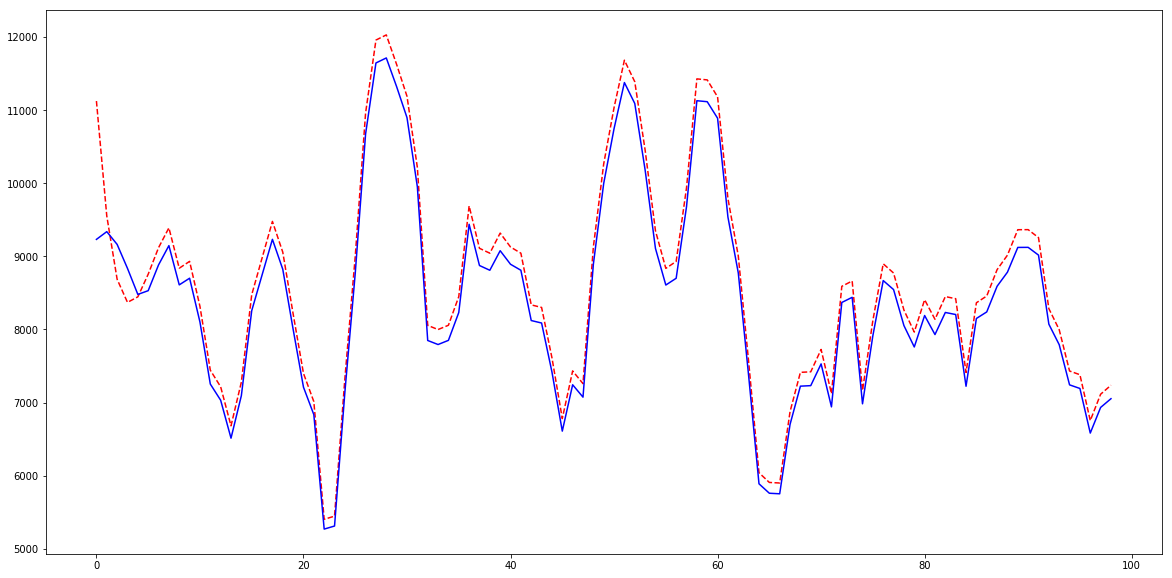

y_test [ 11122.87972028   9551.16958042   8686.20505051   8370.37867133
   8446.08298368   8755.71052836   9118.07696193   9389.03166278
   8837.47797203   8930.97000777   8315.32160062   7443.48379953
   7216.06266511   6682.8496115    7280.64141414   8474.22715618
   8976.19409479   9477.27874903   9056.81814297   8213.53923854
   7399.72051282   7013.73939394   5404.95376845   5447.95955711
   7331.21585082   8999.5967366   10959.19110334  11956.31954157
  12026.83710179  11622.2496115   11187.49848485  10215.34094794
   8055.84529915   7998.97377622   8057.49343434   8448.81227661
   9688.64269619   9109.54292929   9042.71025641   9317.65501166
   9126.95858586   9042.7993784    8336.19176379   8301.22463092
   7613.87991453   6781.93356643   7433.44926185   7259.46208236
   9125.47094017  10263.03721834  11033.04980575  11680.93939394
  11387.16825952  10453.60621601   9349.55866356   8835.17575758
   8930.12171717   9937.00854701  11425.7028749   11411.83543124
  11179.77668998  

In [35]:
'''
Winter of house 3273.
'''
model_history,y_test,y_pred,w1,w2,b1,b2 = nn_model(winter,1,"mean_squared_error",winter1.shape[0])

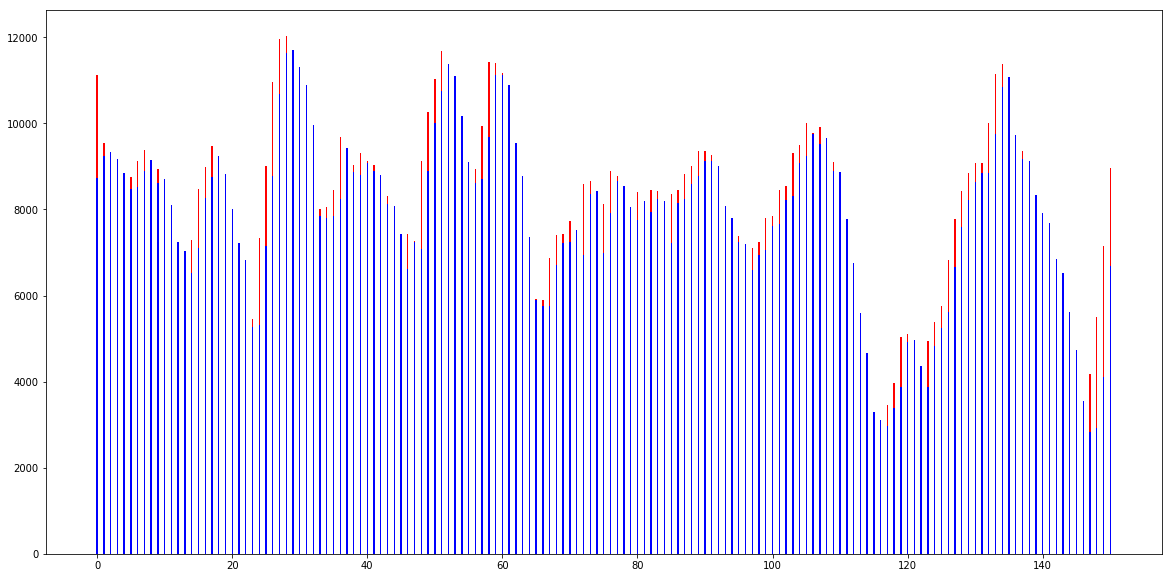

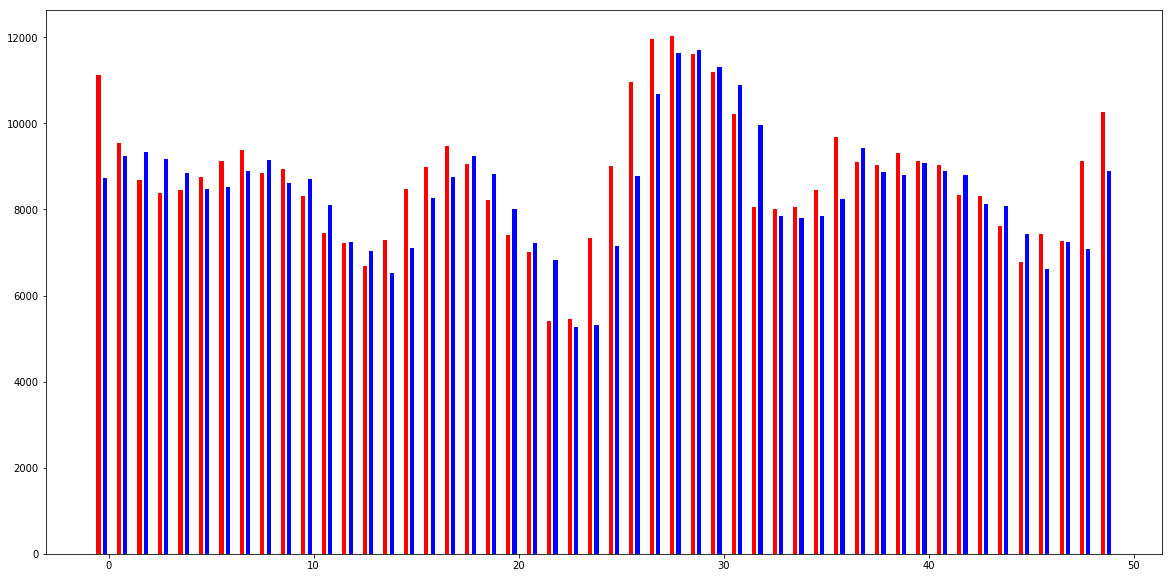

In [38]:
# red - 1st argument
# blue - 2nd argument
'''
1st graph is just to see where all y_test is more than y_pred
2nd graph is used to compare them side by side - so give small window size for clarity
'''
plot_bar(y_test.tolist(),y_pred.T[0].tolist(),0,len(y_test),"",1)
plot_bar(y_test.tolist(),y_pred.T[0].tolist(),0,50,"")

In [39]:
#
#
#
#
#
#
#
# --------------------- Till there refer for summers and winters NN model implementation for house 3273------------------------
#
#
#
#
#
#
#
#

In [ ]:
'''
kth nearest neighbour regressor
'''
x_train = summer1.values[:,:-1]
y_train = summer1.values[:,-1:]
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_train)

r2 = r2_score(y_train,y_pred)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
mae = mean_absolute_error(y_train,y_pred)

print ("R2 Score : ",r2)
print ("RMSE : ",rmse)
print ("MAE : ",mae)
plot_test(y_train,y_pred,0,100,"")

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


R2 Score :  0.192688216892
RMSE :  2688.26149905
MAE :  1926.0673486


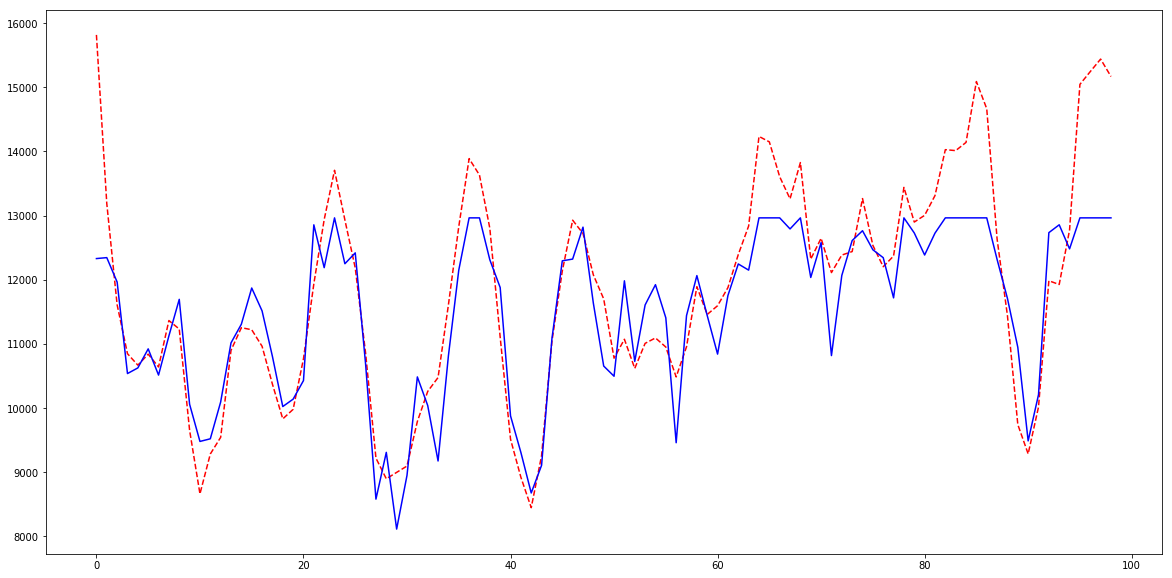

In [42]:
#extra trees
X_train = summer1.values[:,0].reshape(-1, 1) 
y_train = summer1.values[:,1]
X_test = summer2.values[:,0].reshape(-1, 1)
y_test = summer2.values[:,1]
model=ExtraTreesRegressor(n_estimators=500,max_features=None,verbose=1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test,y_pred)
mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)

print ("R2 Score : ",r2)
print ("RMSE : ",np.sqrt(mse))
print ("MAE : ",mae)

plot_test(y_test,y_pred,0,100,"")

In [ ]:
thermal_data.to_csv("df_3273.csv",sep=",",encoding="utf-8")

In [ ]:
'''
Printing the shapes of all the data files available.
'''

hid = [1037,115,2401,3268,3273,4000,6324,6614,9912]

for ti in (hid):
    print ("\n\n House : ",ti)
    df_115 = pd.read_pickle("../DataSets/New_Pecan_Street/load_data_"+str(ti)+".pkl")
    print (df_115.shape)

In [ ]:
'''
Running the model (NN) and comparing on other houses.
'''
d = {}

'''
A list containing the house-ids of the houses considered. Only one house has been dropped, due to the presence of 
NaNs in 'air1' , 'furnace1' and 'waterheater1'. 
'''
#hid = [1037,115,2401,3268,3273,4000,6324,6614,9912]
ti = time.time()
hid = [3273]

for ti in (hid):
    print ("\n\n House : ",ti)
    df_115 = pd.read_pickle("../DataSets/New_Pecan_Street/load_data_"+str(ti)+".pkl")

    df_115 = df_115[["localhour","air1","furnace1","waterheater1"]]
    df_115["total"] = df_115["air1"] + df_115["furnace1"] + df_115["waterheater1"]
    df_115.iloc[:,[1,2,3,4]] = df_115.iloc[:,[1,2,3,4]].mul(1000)
    df_115.head()
    
    '''
    Splitting the dataframe, by segmentation of data, using just the SUMMERS of all the years present.
    Summer : from May to October.
    '''
    

    # changing the shape of the given data from every row being an hour to every row being a day
    # that is, every row will now have all hours thermal load data as columns (0,1..23) in x and that day's total load in y
    # shapes being x = (1700,24), y = (1700,1)
    
    nhrs = int(df_115["total"].values.shape[0]/24)
    y_115 = np.ndarray(shape=(nhrs,))
    x_115 = np.ndarray(shape=(nhrs,24))
    val = []
    for i in range(nhrs):
        #val = df_tot_ther.values[i:i+24]
        #Take only the loads correspondin to one whole day, starting from the hour the datframe starts from.
        val = df_115["total"].values[24*i:24*(i+1)]
        y_115[i] = np.sum(val)
        x_115[i]=val.T
    y = pd.DataFrame(y_115)
    y.columns = ['day_load']
    x = pd.DataFrame(x_115)
    x.head()

    # creating the desired shape for the ANN model - 168 columns for hour-wise data of 7 days as input
    #  and next day total load as output
    temp = x.values.tolist()
    x = np.ndarray(shape=(nhrs,168))
    for i in range(7,len(temp),1):
        dlist = []
        for j in range(1,8):
            dlist = dlist + temp[i-j]
        x[i] = dlist
    x = pd.DataFrame(x)
    x.tail(10)

    x = x.iloc[7:,:]
    y = y.iloc[7:,:]
    print(x.shape)
    print(y.shape)

    d_115 = pd.concat([x,y],axis=1)
    print(d_115.shape)
    d_115.head(10)

    thermal_dict1={}
    model_history1={}
    thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model(d_115,thermal_dict1,2,"mean_squared_error",1,0) 
    #print (thermal_dict1)
    d.setdefault(ti,[]).append(thermal_dict1)
tf=time.time()    
print ("Time Taken : ",tf-ti)

In [ ]:
print ("Dict  in 'house-id' '-' ['R^2','RMSE','MAE']: \n")
for key,val in d.items():
    print (key," - ",val,"\n")

In [ ]:
master_dict= {}
ti = time.time()
activations = ["relu","elu","selu","softplus","linear"]
for i in activations:
    thermal_dict1={}
    model_history1={}
    thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model(d,thermal_dict1,1,"mean_squared_error",1,0,i)
    master_dict[i] = thermal_dict1
tf = time.time()
#print("\nweights",w1,"\nbiases",b1,"\nweights",w2,"\nbiases",b2)
#print("\ny_pred",y_pred1,"\ny_test",y_test1)
print (" Total Time Taken : ",tf-ti)

In [ ]:
print ("Master Dict : \n")
for key,val in master_dict.iteritems():
    print (key," - ",val,"\n\n")

In [ ]:
y

In [ ]:
master_dict= {}
ti = time.time()
activations = ["relu","elu","selu","softplus","linear"]
for i in activations:
    thermal_dict1={}
    model_history1={}
    thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model_24(x,y,thermal_dict1,1,"mean_squared_error",1,0,i)
    master_dict[i] = thermal_dict1
tf = time.time()
#print("\nweights",w1,"\nbiases",b1,"\nweights",w2,"\nbiases",b2)
#print("\ny_pred",y_pred1,"\ny_test",y_test1)
print (" Total Time Taken : ",tf-ti)

In [ ]:
print ("Master Dict : \n")
for key,val in master_dict.iteritems():
    print (key," - ",val,"\n\n")

In [ ]:
y_test1[0],y_pred1[0]

In [ ]:
di={}
for i in range(y_test1.shape[0]):
  di[i] = abs(np.sum(y_pred1[i])-np.sum(y_test1[i]))
for key,val in di.iteritems():
    print (key," - ",val,"\n")

In [ ]:
np.mean(di.values())

In [ ]:
data = pd.read_pickle('../DataSets/New_Pecan_Street/load_data_1632.pkl')
for i in data.columns:
    if data[i].isnull().sum() >= data.values.shape[0]-10000 : del data[i]
data.columns        

In [ ]:
data = pd.DataFrame(data.values[175:],columns=data.columns)
d_localhour = data[["localhour"]]
data = data.mul(1000)
data.head()

In [ ]:
d_localhour.head()

In [ ]:
data['air1'][34492] = (data['air1'][34492-168] + data['air1'][34492+168])/2
data['air2'][34492] = (data['air2'][34492-168] + data['air2'][34492+168])/2
data['grid'][34492] = (data['grid'][34492-168] + data['grid'][34492+168])/2
data['outsidelights_plugs1'][34492] = (data['outsidelights_plugs1'][34492-168] + data['outsidelights_plugs1'][34492+168])/2
data['outsidelights_plugs2'][34492] = (data['outsidelights_plugs2'][34492-168] + data['outsidelights_plugs2'][34492+168])/2
data['refrigerator1'][34492] = 0.0
x = data.values[34492][2:]
data['use'][34492] = sum(x[1:])

In [ ]:
data.isnull().sum()

In [ ]:
df_thermal = data[['air1','air2','air3','furnace1','furnace2','waterheater1']].copy()
df_thermal['tot'] = df_thermal['air1'] + df_thermal['air2'] + df_thermal['air3'] + df_thermal['furnace1'] + df_thermal['furnace2'] + df_thermal['waterheater1']
df_tot_ther = df_thermal[['tot']]

In [ ]:
df_thermal = pd.concat([d_localhour,df_thermal],axis=1)

In [ ]:
df_tot_ther.iloc[23]

In [ ]:
df_thermal.values.tolist()[0]

In [ ]:
df_thermal.head()

In [ ]:
# changing the shape of the given data from every row being an hour to every row being a day
# that is, every row will now have all hours thermal load data as columns (0,1..23) in x and that day's total load in y
# shapes being x = (1700,24), y = (1700,1)
nhrs = int(df_tot_ther.values.shape[0]/24)
y = np.ndarray(shape=(nhrs,24))
x = np.ndarray(shape=(nhrs,24))
val = []
for i in range(nhrs):
    #val = df_tot_ther.values[i:i+24]
    #Take only the loads correspondin to one whole day, starting from the hour the datframe starts from.
    val = df_tot_ther.values[24*i:24*(i+1)]
    y[i] = val.T
    x[i]=val.T

In [ ]:
x.shape

In [ ]:
y = pd.DataFrame(y)
#y.columns = ['day_load']
x = pd.DataFrame(x)
x.head()

In [ ]:
y.head()

In [ ]:
# creating the desired shape for the ANN model - 168 columns for hour-wise data of 7 days as input
#  and next day total load as output
temp = x.values.tolist()
x = np.ndarray(shape=(nhrs,168))
for i in range(7,len(temp),1):
    dlist = []
    for j in range(1,8):
        dlist = dlist + temp[i-j]
    x[i] = dlist
x = pd.DataFrame(x)
x.tail(10)

In [ ]:
x.head(10)

In [ ]:
print (x.shape , y.shape)

In [ ]:
x = x.iloc[7:,:]
y = y.iloc[7:,:]
print(x.shape)
print(y.shape)

In [ ]:
'''
Don't run this part, when the NN model has 24 output nodes.
'''
d = pd.concat([x,y],axis=1)
print(d.shape)
d.head(10)

In [ ]:
#To check if an error is present.
sum(d.values.tolist()[0][:24]) == d.values.tolist()[0][-1]

In [ ]:
# sanity check to see if output has next day load only and inputs are all previous 7 days data
all_rows_sums = []
for i in range(d.shape[0]):
    sums = {}
    for k in range(7):
        f = d.iloc[i,24*k:24*(k+1)]
        sums['day'+str(k+1)] = sum(f)
    sums['next day tot'] = d.iloc[i,-1:]
    all_rows_sums.append(sums)
all_rows_sums

In [ ]:
x.head()

In [ ]:
y.head()

In [ ]:
#Sanity Check.
sum(x.values.tolist()[1][:24]) == sum(y.values.tolist()[0])

In [ ]:
# all  below this point not necessary for consideration...
# check the 24*7 input and next day load prediction model only till this point

In [ ]:
w_read = pd.read_csv("weather_data1.csv",dtype='object')
for i in w_read.columns:
    if w_read[i].isnull().sum() >= w_read.values.shape[0]-60000 : del w_read[i]
'''
t1 = weather['latitude'].str.contains('30.')
t2 = [c for c in range(len(t1)) if t1[c] == True]
t2[-1]
'''
w_read = pd.DataFrame(w_read.values[19495:58821], columns=w_read.columns)
w_read.isnull().sum()

In [ ]:
weather = pd.DataFrame(w_read.iloc[:,1:], columns=w_read.columns[1:])
for i in weather.columns:
    if(i!='timestamp'):
        print(i)
        weather[i] = pd.to_numeric(weather[i])
        if(weather[i].isnull().sum()!=0):
            for j in range(weather.values.shape[0]):
                if(np.isnan(weather[i][j])):
                    weather[i][j] = 0.0
weather.isnull().sum()

In [ ]:
df_tot_ther = pd.DataFrame(df_tot_ther.values[:39326], columns=df_tot_ther.columns)
weather['total_load'] = df_tot_ther[['tot']]
del weather['mean_load']

In [ ]:
weather.shape

In [ ]:
weather.tail()

In [ ]:
thermal_dict1 = {}
model_history1 = {}
ti = time.time()
thermal_dict1,model_history1,y_test1,y_pred1,scores,w1,w2,b1,b2 = nn_model(weather,thermal_dict1,1,"mean_squared_error",weather.shape[1]-1,0)
tf = time.time()
print("\nweights",w1,"\nbiases",b1,"\nweights",w2,"\nbiases",b2)
print("\ny_pred",y_pred1,"\ny_test",y_test1)
print ("Time Taken : ",tf-ti)
print (thermal_dict1)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime

x = [datetime.datetime(2011, 1, 4, 0, 0),
     datetime.datetime(2011, 1, 5, 0, 0),
     datetime.datetime(2011, 1, 6, 0, 0)]
x = date2num(x)

y = [4, 9, 2]
z=[1,2,3]
k=[11,12,13]

ax = plt.subplot(111)
ax.bar(x-0.2, y,width=0.2,color='b',align='center')
ax.bar(x, z,width=0.2,color='g',align='center')
ax.bar(x+0.2, k,width=0.2,color='r',align='center')
ax.xaxis_date()

plt.show()